# Rabi Cycle

- Quantum Algorithm for Time-Dependent Hamiltonian Simulation by Permutation Expansion ([here](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030342))
- Rabi Cycle Document ([here](https://drive.google.com/file/d/1Zt7ElAQkwPb9YGTptcb9iPo2liSLBOC7/view?usp=sharing))

In [1]:
import qiskit as q
import numpy as np
import matplotlib as mpl
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates.z import ZGate
from qiskit_experiments.library import StateTomography

In [2]:
# from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(group='ornl')
# backend = provider.get_backend('ibmq_guadalupe')

In [3]:
w = 0

### Assigning Qubit numbers 

In [4]:
i1 = 14
i2 = 13
i3 = 12
i4 = 11
k1 = [10, 9]
k2 = [8, 7]
k3 = [6, 5]
k4 = [4, 3]
x = 2
z = 1
ancilla = 0

### Initializing the quantum registers

In [5]:
q_i = q.QuantumRegister(4, 'i_reg')
q_k = q.QuantumRegister(8, 'k_reg')
q_x = q.QuantumRegister(1, 'x')
q_z = q.QuantumRegister(1, 'z')
q_ancilla = q.QuantumRegister(1, 'ancilla')
c_z = q.ClassicalRegister(1, 'measure_z')

### Calculating $s_q$ values

$s_q = \frac{(ln 2)^q}{q!}$

In [6]:
ln2 = np.log(2)
s = [(ln2 ** q)/np.math.factorial(q) for q in range(0, 5)]

### Calculating $\theta$ values

$\theta_i = 2\tan^{-1}{\sqrt{\frac{\sum_{q=i}^{4} s_q}{s_{i-1}}}}$

In [7]:
theta = [2*np.arctan(np.sqrt(np.sum(s[i:5])/s[i - 1])) for i in range(1, 5)]
theta = [0] + theta

## 1. State Preparation

$ |\psi_0 \rangle = \frac{1}{\sqrt{s}} \sum_{q = 0}^{4} \sum_{\textbf{i}_q} \sum_{\textbf{k}_q} \sum_{x = 0, 1} \sqrt{\frac{(\ln{2})^q}{2q!}} | \textbf{i}_q \rangle | \textbf{k}_q \rangle |x \rangle$

In [8]:
def state_prep():
    qc = q.QuantumCircuit(15, name='state prep')
    qc.h(x)
    qc.u(theta[1], 0, 0, i1)
    qc.cu(theta[2], 0, 0, 0, i1, i2)
    qc.cu(theta[3], 0, 0, 0, i1, i3)
    qc.cu(theta[4], 0, 0, 0, i1, i4)
    qc.barrier()
    qc.cx(i1, k1[1])
    qc.cx(i2, k2[1])
    qc.cx(i3, k3[1])
    qc.cx(i4, k4[1])
    qc.barrier()
    qc.ch(i1, k1[0])
    qc.ccx(i1, k1[0], k1[1])
    qc.ch(i2, k2[0])
    qc.ccx(i2, k2[0], k2[1])
    qc.ch(i3, k3[0])
    qc.ccx(i3, k3[0], k3[1])
    qc.ch(i4, k4[0])
    qc.ccx(i4, k4[0], k4[1])
    return qc

#### Testing state preparation

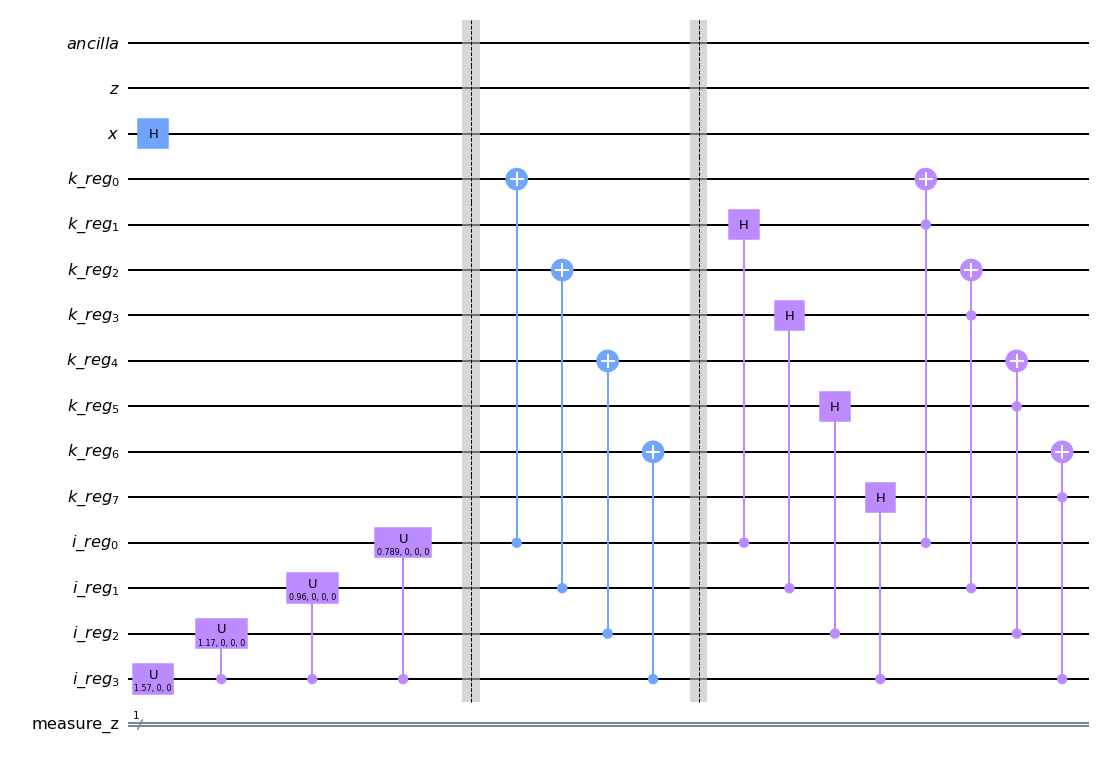

In [9]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(state_prep(), range(0, 15))
qc.decompose().draw(output='mpl')

## 2. Controlled Unitaries

#### $V_{c P} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle P_{\textbf{i}_q} |z \rangle$

In [10]:
def V_cP():
    qc = q.QuantumCircuit(15, name='V_cP')
    qc.cx(i1, z)
    qc.cx(i2, z)
    qc.cx(i3, z)
    qc.cx(i4, z)
    return qc

#### Testing $V_{cP}$

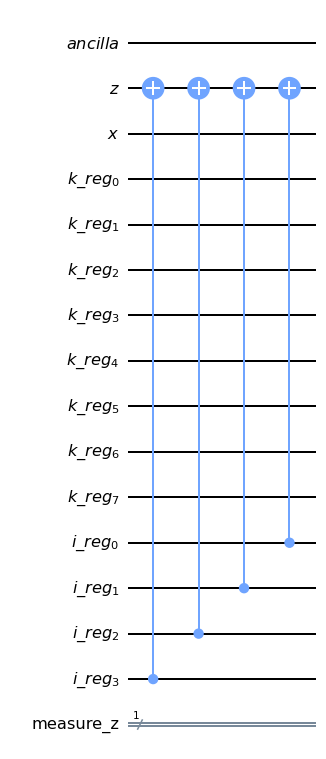

In [11]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_cP(), range(0, 15))
qc.decompose().draw(output='mpl')

#### $V_{c i} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle (-1)^q |z \rangle$

In [12]:
def V_ci():
    qc = q.QuantumCircuit(15,name='V_ci')
    qc.s(i1).inverse()
    qc.s(i2).inverse()
    qc.s(i3).inverse()
    qc.s(i4).inverse()
    return qc

#### Testing $V_{ci}$

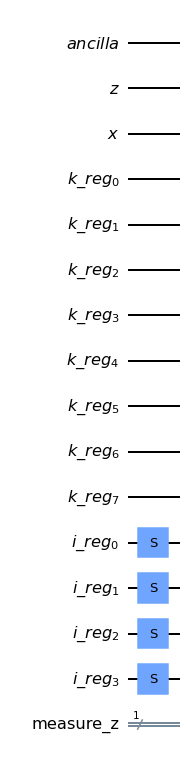

In [13]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_ci(), range(0, 15))
qc.decompose().draw(output='mpl')

### $V_{c \phi}$

#### Function to compute exponential divided-difference

$f(x) = e^{x \ln{2}}$

In [14]:
# Function: exp(xln(2))
def divided_diff(xs):
    xs = np.sort_complex(xs)
    if len(xs) == 1:
        return np.exp(np.log(2) * xs[0])
    
    if len(xs) == 2 and (xs[0] == xs[1]):
        return np.log(2) * np.exp(np.log(2) * xs[0])
    
    if len(xs) == 3 and (xs[0] == xs[1] == xs[2]):
        return 0.5 * np.log(2) * np.log(2) * np.exp(np.log(2) * xs[0])
    
    return (divided_diff(xs[:-1]) - divided_diff(xs[1:])) / (xs[0] - xs[-1])

#### Function to compute $x_j$ values

$x_j = i \left( E_{z_{\textbf{i}_q}} - E_{z_{\textbf{i}_{j-1}}} \right) + \sum_{l=j}^{q} \lambda_{i_l, z_{\textbf{i}_l}}^{(k_l)} = i \left( E_{z_{\textbf{i}_q}} - E_{z_{\textbf{i}_{j-1}}} + \sum_{l=j}^{q} (-1)^{k_l +1} \omega \right)$

In [15]:
def calculate_xjs(q, z, k_vals):
    E = [1, -1]
    xjs = []
    for j in range(1, q+1):
        xj = (((-1) ** q) * E[z] -  ((-1) ** (j-1)) * E[z] + np.sum([((-1) ** (k + 1)) * w for k in k_vals[j-1:]])) * 1j
        xjs.append(xj)
    return xjs
# calculate_xjs(3, 0, [1, 1, 1])

#### Function to compute angles $\theta$ and $\phi$

$\theta_{{\textbf{i}_q}, z}^{({\textbf{k}_q})} = \arg{\left[\frac{e^{\Delta t [x_1, x_2, . . . x_q, 0]}e^{i t_w \sum_{l=1}^{q} (-1)^{k_l +1} \omega}}{\frac{\widetilde{\Delta t_w}^q}{q!}}\right]}$

$\phi_{{\textbf{i}_q}, z}^{({\textbf{k}_q})} = \cos^{-1}{\left[\left|{\frac{e^{\Delta t [x_1, x_2, . . . x_q, 0]}e^{i t_w \sum_{l=1}^{q} (-1)^{k_l +1} \omega}}{\frac{\widetilde{\Delta t_w}^q}{q!}}}\right|\right]}$

In [16]:
def compute_angle_diff(q, z, x, k_vals, tw):
    energy_diff = calculate_xjs(q, z, k_vals) + [0]

    denom = ((np.log(2))**q) / np.math.factorial(q)
    div_diff = divided_diff(energy_diff)
    result = div_diff / denom

    lambda_sum = np.sum([((-1) ** (k + 1)) * w for k in k_vals]) * 1j
    d_factor = np.exp(tw * lambda_sum)

    # (1/2)^q part of the d_factor is cancelled by the denominator. So we have not computed that

    theta = np.angle(result * d_factor)
    phi = np.arccos(np.absolute(result * d_factor))

    # Convert theta from (-pi, pi] to [0, 2pi)
    if theta < 0:
        theta = 2*np.pi + theta

    sum = (theta + phi) % (2*np.pi)
    diff = (theta - phi) % (2*np.pi)

    if diff < 0:
        diff =  2*np.pi + diff

#     sum = round(sum, 5)
#     diff = round(diff, 5)
    
    if x == 1:
        return diff
    else:
        return sum

In [17]:
def generate_control_states(q_val):
    '''
    # A control state is of the form: xx-(xx)n-xxxx
    # The first two xx correspond to z and x respectively
    # The last four xxxx store the value of q. 0001 means q is 1, 0011 means q is 2 and so on
    # Each (xx) in the middle corresponds to k-values. Since the order of digits is reversed, 01 means 2 and 10 means 1.
    # In conclusion, a control state is of the form zx-(k4)-(k3)-(k2)-(k1)-qqqq
    # The number of k values, and hence the length of the control state, depends on q. If q = n, n k-values are present
    # Example: control state 111010010111 -> z = 1, x = 1, k3 = 1, k2 = 1, k1 = 2, q = 3
    '''
    num_of_k = q_val
    binary_list = [bin(x)[2:].zfill(num_of_k) for x in range(2**num_of_k)]
    ctrl_states = []
    for state in binary_list:
        ctrl_state = ""
        for digit in state:    
            if digit == "0":
                ctrl_state += "10"
            else:
                ctrl_state += "01"
        for zx in ["00", "01", "10", "11"]:
            ctrl_states.append(zx + ctrl_state + "0" * (4 - q_val) + "1" * q_val)  
    return ctrl_states
# generate_control_states(2)

$U_{\Phi} = \begin{pmatrix}
       1 & 0 \\
       0 & e^{i \left(\theta_{{\textbf{i}_q}, z}^{({\textbf{k}_q})} + (-1)^x \phi_{{\textbf{i}_q}, z}^{({\textbf{k}_q})}\right)}
    \end{pmatrix}$

In [18]:
def U_phi(ctrl_state, q_val, tw):
    z_val = int(ctrl_state[0])
    x_val = int(ctrl_state[1])
    k_vals = []
    for i in range(q_val):
        if ctrl_state[2 + 2*i] == "0":
            k_vals.append(2)
        else:
            k_vals.append(1)
    k_vals.reverse()
    # k_vals has integer values (1 or 2) in ascending order: k1, k2, k3, k4
    
    angle = compute_angle_diff(q_val, z_val, x_val, k_vals, tw)
    qc = q.QuantumCircuit(1)
    qc.p(angle, 0)
    return qc

# U_phi("0010010011", 3, 0)

#### $V_{c \phi} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle \Phi_{{\textbf{i}_q}, x}^{({\textbf{k}_q}, w)} |z \rangle$

In [19]:
def V_cphi(tw):
    qc = q.QuantumCircuit(15, name='V_cphi')
    qc.x(ancilla)
    for q_val in range(1, 5):
        control_states = generate_control_states(q_val)
        num_ctrl = len(control_states[0])
        for ctrl_state in control_states:
            gate = U_phi(ctrl_state, q_val, tw).to_gate(label='U_phi({})'.format(ctrl_state)).control(num_ctrl, ctrl_state=ctrl_state)
            if num_ctrl == 8:
                qc.append(gate, [i1, i2, i3, i4, k1[0], k1[1], x, z,ancilla])
            if num_ctrl == 10:
                qc.append(gate, [i1, i2, i3, i4, k1[0], k1[1], k2[0], k2[1], x, z,ancilla])
            if num_ctrl == 12:
                qc.append(gate, [i1, i2, i3, i4, k1[0], k1[1], k2[0], k2[1], k3[0], k3[1], x, z,ancilla])
            if num_ctrl == 14:
                qc.append(gate, [i1, i2, i3, i4, k1[0], k1[1], k2[0], k2[1], k3[0], k3[1], k4[0], k4[1], x, z,ancilla])
        
    qc.x(ancilla)    
    return qc

#### Testing $V_{c\phi}$

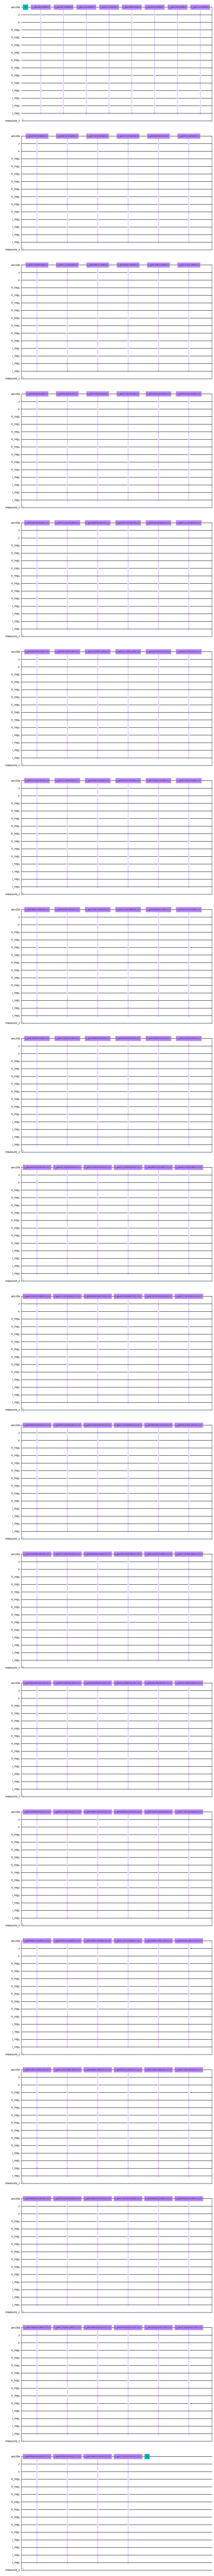

In [20]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_cphi(0), range(0, 15))
qc.decompose().draw(output='mpl')

## 3. Combining state preparation and controlled unitaries

#### $W = ( B ^{\dagger} \otimes \mathbb{1}) V_{c i} V_{c P} V_{c \phi} ( B \otimes \mathbb{1})$
where $B$ is the state preparation unitary $B |0 \rangle = | \psi_0 \rangle$

In [21]:
def W(tw, global_phase = 0):
    qc = q.QuantumCircuit(15, name='W', global_phase = global_phase)
    qc.append(state_prep(), range(0, 15))
    qc.barrier()
    qc.append(V_cphi(tw), range(0, 15))
    qc.barrier()
    qc.append(V_cP(), range(0, 15))
    qc.barrier()
    qc.append(V_ci(), range(0, 15))
    qc.barrier()
    qc.append(state_prep().inverse(), range(0, 15))
    qc.barrier()
    return qc

#### Testing $W$

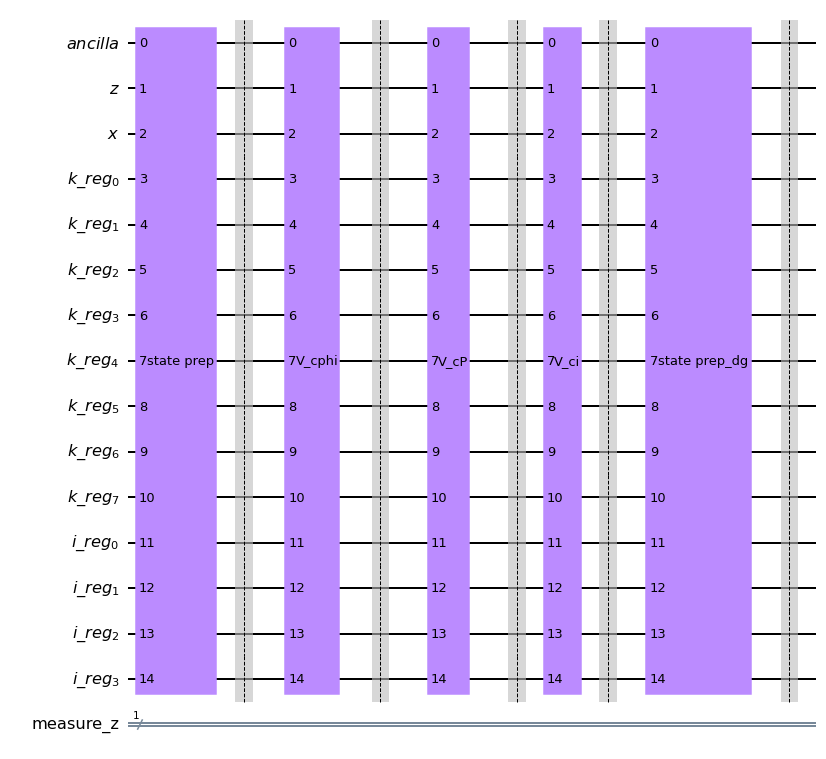

In [22]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(W(0), range(0, 15))
qc.decompose().draw(output='mpl')

#### $R = \mathbb{1} - 2( | 0 \rangle \langle 0 | \otimes \mathbb{1})$

In [23]:
def R():
    qc = q.QuantumCircuit(13, name='R')
    qc.x(range(0, 13))
    zgate = ZGate().control(12, ctrl_state='111111111111')
    qc.append(zgate, range(12, -1, -1))
    qc.x(range(0, 13))
    return qc

#### Testing $R$

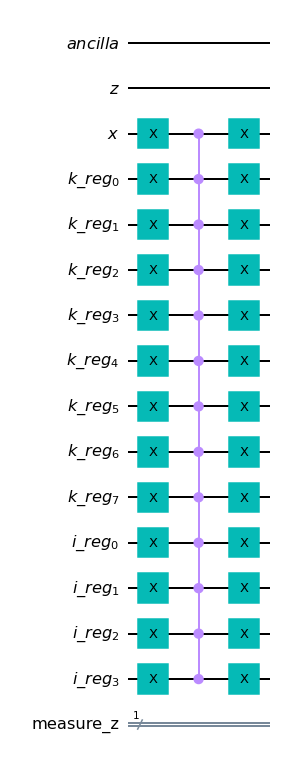

In [24]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(R(), range(2, 15))
qc.decompose().draw(output='mpl')

#### $A = - WRW^{\dagger} RW$

In [25]:
def A(tw):
    qc = q.QuantumCircuit(15, name='A ({})'.format(tw))
    qc.append(W(tw), range(0, 15))
    qc.append(R(), range(2, 15))
    qc.append(W(tw).inverse(), range(0, 15))
    qc.append(R(), range(2, 15))
    qc.append(W(tw, global_phase=np.pi), range(0, 15))
    return qc

#### Testing $A$

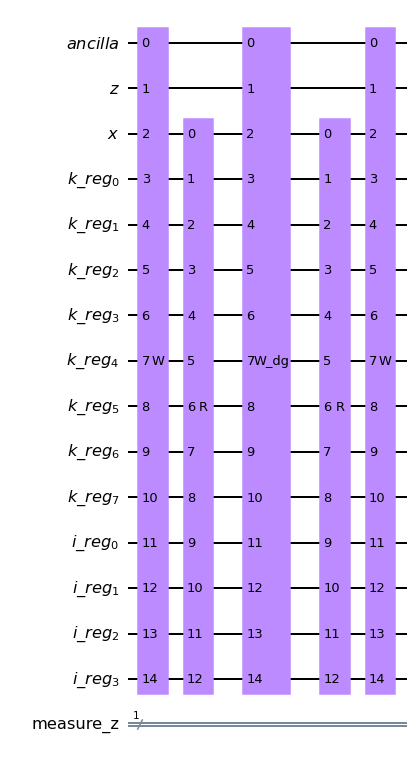

In [26]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(A(0), range(0, 15))
qc.decompose().draw(output='mpl')

## 4. Principal diagonal matrix $H_0$

$ H_0 = Z $

$ e^{-i \Delta t H_0} = e^{-i \Delta t Z} = \begin{pmatrix}
       e^{-i \Delta t} & 0 \\
       0 & e^{i \Delta t}
    \end{pmatrix}$

In [27]:
def principal_diag(evolution_time):
    qc = q.QuantumCircuit(1, name="p_diag({})".format(evolution_time))
    qc.rz(2*evolution_time, 0)
    return qc

#### Testing $e^{-i \Delta t H_0}$

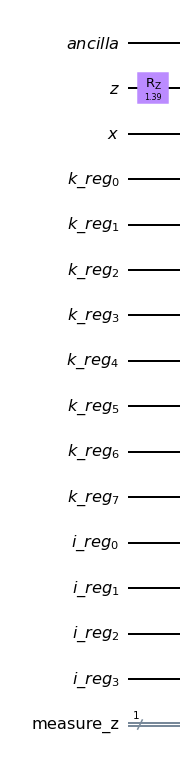

In [28]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(principal_diag(ln2), [1])
qc.decompose().draw(output='mpl')

## 5. Final Quantum Circuit

### Initializing the quantum circuit

In [29]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)

### Setting the time of evolution

The evolution time is set in multiples of $\ln{2}$ because $\Delta t = \ln{2}$

In [30]:
evolution_time = ln2 * 2
tw = 0
for i in range(int(evolution_time / ln2)):
    qc.append(A(tw), range(0, 15))
    tw += ln2
qc.append(principal_diag(evolution_time), [z])
qc.measure(q_z, c_z)

### Drawing the quantum circuit (high level overview)

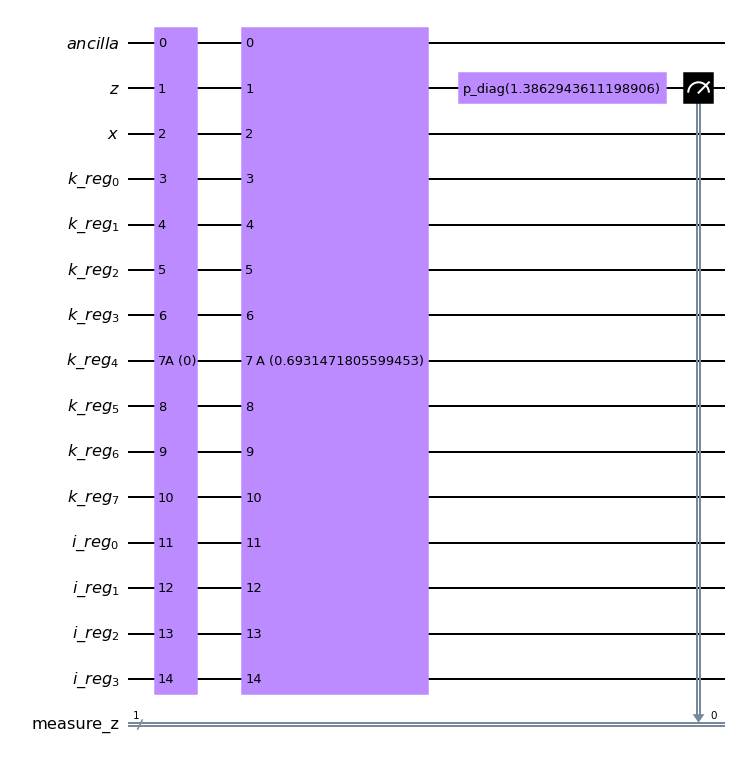

In [31]:
qc.draw(output='mpl')

### Performing measurements in Z-basis

In [32]:
backend = q.Aer.get_backend('qasm_simulator')
job = q.execute(qc, backend, shots=1000)

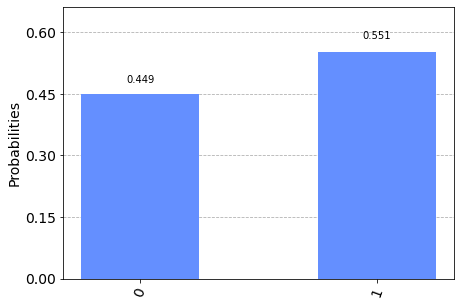

In [33]:
result = job.result()
counts = result.get_counts(qc)
graph = q.visualization.plot_histogram(counts)
display(graph)

### Performing measurement in X basis

In [34]:
qc_x = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
evolution_time = ln2 * 2
tw = 0
for i in range(int(evolution_time / ln2)):
    qc_x.append(A(tw), range(0, 15))
    tw += ln2
qc_x.append(principal_diag(evolution_time), [z])
qc_x.h(range(0, 15))

In [35]:
qc_x.measure(q_z, c_z)

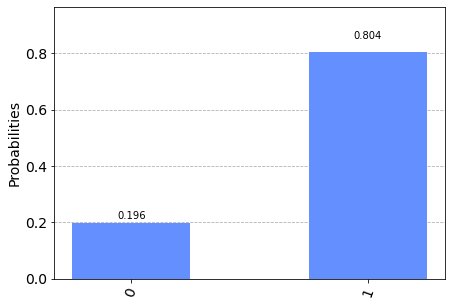

In [36]:
backend = q.Aer.get_backend('qasm_simulator')
job = q.execute(qc_x, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc_x)
graph = q.visualization.plot_histogram(counts)
display(graph)

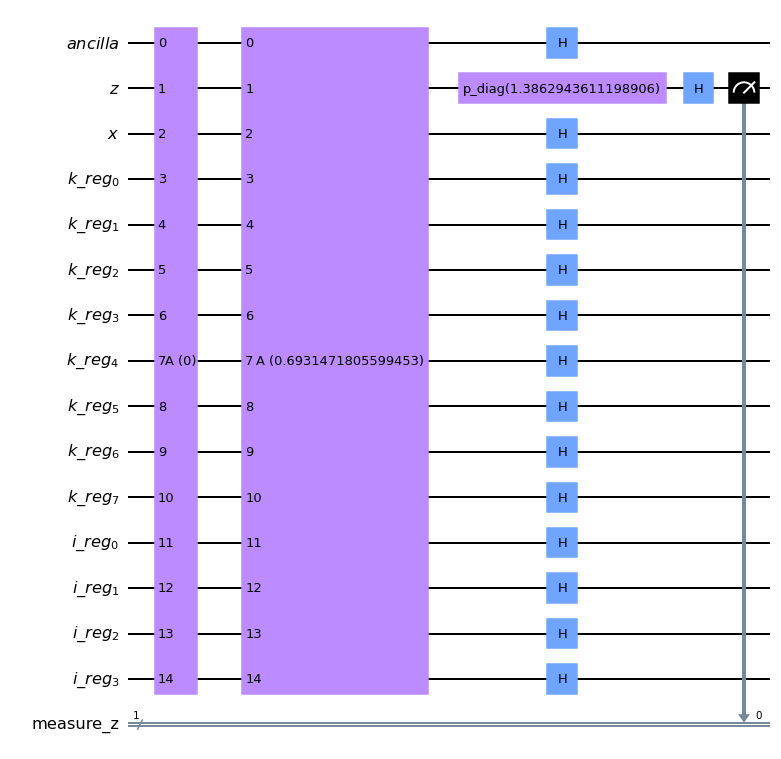

In [37]:
qc_x.draw(output='mpl')

### Performing measurement in Y-basis

In [38]:
qc_y = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
tw = 0
for i in range(int(evolution_time / ln2)):
    qc_y.append(A(tw), range(0, 15))
    tw += ln2
qc_y.append(principal_diag(evolution_time), [z])

qc_y.s(range(0, 15)).inverse()
qc_y.h(range(0, 15))
qc_y.measure(q_z, c_z)

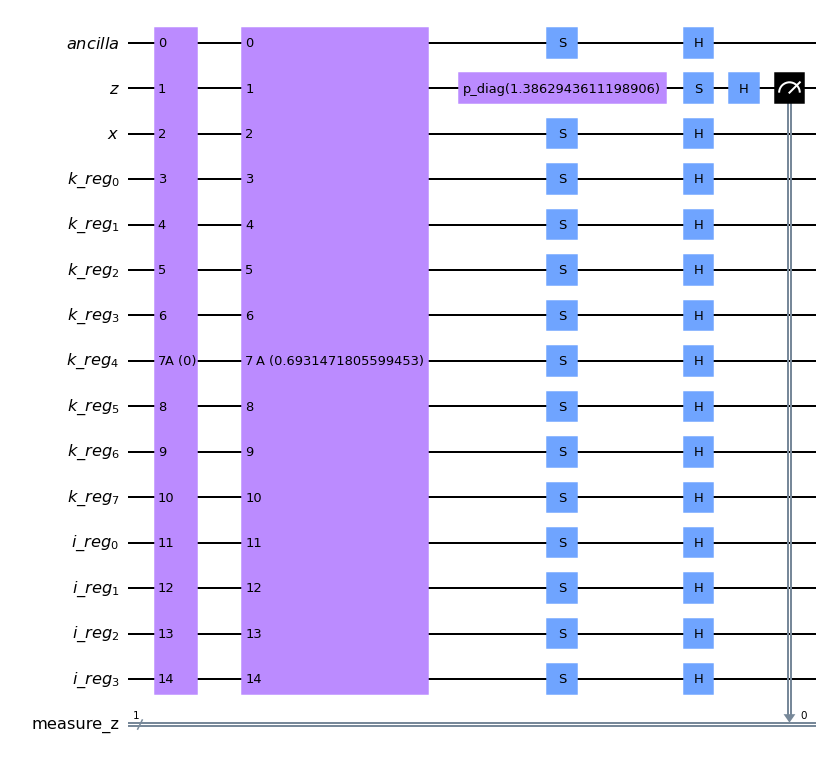

In [39]:
qc_y.draw(output='mpl')

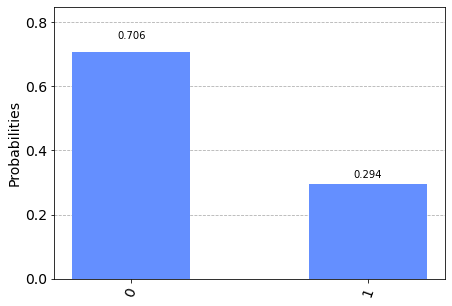

In [40]:
backend = q.Aer.get_backend('qasm_simulator')
job = q.execute(qc_y, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc_y)
graph = q.visualization.plot_histogram(counts)
display(graph)

## Tomography

In [ ]:
# backend = q.Aer.get_backend('qasm_simulator')
qstexp1 = StateTomography(qc, measurement_qubits=[z])
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)